# Shakespeare


```{contents}
:local:
```


In [296]:
from __future__ import annotations

import os
import time
import seaborn as sns

import matplotlib.pyplot as plt
from pathlib import Path
from typing import Any, Dict, List, Literal, Tuple, Union

import numpy as np
from numpy.typing import ArrayLike, NDArray
import requests
import tiktoken
import torch
from rich.pretty import pprint
from torch import nn
from torch.utils.data import DataLoader, Dataset
import os
import random
import warnings

import numpy as np
import torch
import torch.nn.functional as F
import torch.backends.cudnn

from pydantic import BaseModel, Field, model_validator, computed_field


## Composing the Configurations

In [297]:
class Composer(BaseModel):
    seed: int = 2024
    debug: bool = False

    url: str = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
    dataset_name: str = "tinyshakespeare"
    data_folder: str = Field(default="./data/tinyshakespeare", description="Path to the data folder")

    train_path: Path = Field(None, description="Path to the train file")
    valid_path: Path = Field(None, description="Path to the valid file")

    encoding_name: Literal['gpt2', 'r50k_base', 'p50k_base', 'p50k_edit', 'cl100k_base'] = "gpt2"

    batch_size: int = Field(default=64, description="Batch size")
    block_size: int = Field(default=128, description="Block size, an alias for max length/context window size.", alias="context_length")
    device_type: Literal["cpu", "cuda"] = "cpu"
    device: torch.device = Field(None, description="Device to use")

    # model parameters
    d_model: int = Field(default=512, description="Dimension of the model")
    d_ff: int = Field(default=None, description="Dimension of the feed forward layer")
    H: int = Field(default=8, description="Number of heads", alias="num_heads")
    vocab_size: int = Field(default=50257, description="Vocabulary size")
    num_decoder_blocks: int = Field(default=6, description="Number of decoder blocks")


    @model_validator(mode="after")
    def set_train_valid_paths(self) -> Composer:
        self.train_path = Path(self.data_folder) / "train.txt"
        self.valid_path = Path(self.data_folder) / "valid.txt"
        return self

    @model_validator(mode="after")
    def set_device(self) -> Composer:
        self.device = torch.device(self.device_type)
        return self

    @model_validator(mode="after")
    def set_debug_fields(self) -> Composer:
        if self.debug:
            self.batch_size = 2
            self.block_size = 8
            self.d_model = 4
        return self

    class Config:
        extra = "forbid"
        arbitrary_types_allowed = True

composer = Composer(debug=True)
pprint(composer)


Composer(
│   seed=2024,
│   debug=True,
│   url='https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt',
│   dataset_name='tinyshakespeare',
│   data_folder='./data/tinyshakespeare',
│   train_path=PosixPath('data/tinyshakespeare/train.txt'),
│   valid_path=PosixPath('data/tinyshakespeare/valid.txt'),
│   encoding_name='gpt2',
│   batch_size=2,
│   block_size=8,
│   device_type='cpu',
│   device=device(type='cpu'),
│   d_model=4,
│   d_ff=None,
│   H=8,
│   vocab_size=50257,
│   num_decoder_blocks=6
)

## Reproducibility

In [298]:
def configure_deterministic_mode() -> None:
    """
    See https://pytorch.org/docs/stable/generated/torch.use_deterministic_algorithms.html
    and https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility
    """
    # fmt: off
    torch.use_deterministic_algorithms(True, warn_only=True)
    torch.backends.cudnn.benchmark        = False
    torch.backends.cudnn.deterministic    = True
    torch.backends.cudnn.enabled          = False

    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
    # fmt: on
    warnings.warn(
        "Deterministic mode is activated. This will negatively impact performance and may cause increase in CUDA memory footprint.",
        category=UserWarning,
        stacklevel=2,
    )


def seed_all(
    seed: int = 1992,
    seed_torch: bool = True,
    set_torch_deterministic: bool = True,
) -> int:
    """
    Seed all random number generators.

    Parameters
    ----------
    seed : int
        Seed number to be used, by default 1992.
    seed_torch : bool
        Whether to seed PyTorch or not, by default True.

    Returns
    -------
    seed: int
        The seed number.
    """
    # fmt: off
    os.environ["PYTHONHASHSEED"] = str(seed)       # set PYTHONHASHSEED env var at fixed value
    np.random.default_rng(seed)                    # numpy pseudo-random generator
    random.seed(seed)                              # python's built-in pseudo-random generator

    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)           # pytorch (both CPU and CUDA)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.enabled = False

        if set_torch_deterministic:
            configure_deterministic_mode()
    # fmt: on
    return seed

In [299]:
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
attention_weights.shape

torch.Size([1, 1, 10, 10])

In [300]:
seed_all(composer.seed, seed_torch=True, set_torch_deterministic=False)

2024

## Tokenization and Vocabulary

- https://huggingface.co/learn/nlp-course/chapter2/4?fw=pt
- https://github.com/openai/tiktoken
- https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb

Language models don't see text like you and I, instead they see a sequence of numbers (known as tokens). Byte pair encoding (BPE) is a way of converting text into tokens. It has a couple desirable properties[^1]:

- It's reversible and lossless, so you can convert tokens back into the original text
- It works on arbitrary text, even text that is not in the tokeniser's training data
- It compresses the text: the token sequence is shorter than the bytes corresponding to the original text. On average, in practice, each token corresponds to about 4 bytes.
- It attempts to let the model see common subwords. For instance, "ing" is a common subword in English, so BPE encodings will often split "encoding" into tokens like "encod" and "ing" (instead of e.g. "enc" and "oding"). Because the model will then see the "ing" token again and again in different contexts, it helps models generalise and better understand grammar.

In [301]:
def am_i_in_jupyter() -> bool:
    try:
        from IPython import get_ipython
        if "IPKernelApp" not in get_ipython().config:
            return False
    except ImportError:
        return False
    return True

IN_JUPYTER = am_i_in_jupyter()

In [302]:
def download(url: str, dataset_name: str, dest_folder: Path | str) -> Path:
    dest_folder_path = Path(dest_folder)

    dest_folder_path.mkdir(parents=True, exist_ok=True)

    filepath = dest_folder_path / f"{dataset_name}.txt"

    response = requests.get(url, stream=True)
    corpus = response.text
    response.raise_for_status()

    with open(filepath, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)

    return filepath, corpus

In [303]:
filepath, corpus = download(composer.url, composer.dataset_name, composer.data_folder)
pprint(filepath)
print(corpus[:100])

PosixPath('data/tinyshakespeare/tinyshakespeare.txt')

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [304]:
N = len(corpus)
train_data = corpus[: int(N * 0.9)]
valid_data = corpus[int(N * 0.9) :]

# encode with tiktoken gpt2 bpe
tokenizer = tiktoken.get_encoding(composer.encoding_name)
tiktoken.list_encoding_names(), tokenizer.n_vocab

(['gpt2', 'r50k_base', 'p50k_base', 'p50k_edit', 'cl100k_base'], 50257)

In [305]:
train_ids = tokenizer.encode_ordinary(train_data)
valid_ids = tokenizer.encode_ordinary(valid_data)
print(f"train has {len(train_ids):,} tokens")
print(f"val has {len(valid_ids):,} tokens")

train has 301,966 tokens
val has 36,059 tokens


In [306]:
print(tokenizer.decode(train_ids[:2]))
print("-" * 80)
print(tokenizer.decode(train_ids[:100]))


First Citizen
--------------------------------------------------------------------------------
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we


In [307]:
# export to bin files
train_ids = np.array(train_ids, dtype=np.uint16)
valid_ids = np.array(valid_ids, dtype=np.uint16)

train_ids.tofile(composer.train_path)
valid_ids.tofile(composer.valid_path)

# train.bin has 301,966 tokens
# val.bin has 36,059 tokens

### STOI (TODO)

- The first `input` is the sentence `hello bot`.
- The tokenization is `[0, 3, 4, 1]` which correctly maps to the tokens `[<SOS>, hello, bot, <EOS>]` as per the `stoi` mapping.
- The shape is `[1, 4]` because we have one sentence with 4 tokens, where the first token is the `<SOS>` token and the last token is the `<EOS>` token.
    - In this context, the first dimension of the shape corresponds to the number of sentences (or samples) in the batch, and the second dimension corresponds to the number of tokens in each sentence.

---

In mathematical terms, we have:

- The vocabulary $\mathcal{V}$ consists of the unique tokens $\{\text{<SOS>, <EOS>, <PAD>, hello, bot, human}\}$ in our text data. The size of the vocabulary is $V = |\mathcal{V}| = 6$.

- We define a function $f_{\text{stoi}}$ that maps each token in our vocabulary to a unique integer index. 
  
  $$
  \begin{aligned}
  f_{\text{stoi}}: \mathcal{V} &\to \{0, 1, ..., V-1\} \\
  v &\mapsto f_{\text{stoi}}(v)
  \end{aligned}
  $$
  
  This function represents the `stoi` mapping in the code. For example, $f_{\text{stoi}}(\text{<SOS>}) = 0$, $f_{\text{stoi}}(\text{hello}) = 3$, etc.

- A sequence of text, such as the sentence "hello bot", is represented as a sequence of token indices $X=(x_1, x_2, x_3, x_4)$ using the $f_{\text{stoi}}$ mapping. For the sentence "hello bot", we have:
  
    $$
    \begin{aligned}
    \mathbf{X} &= (f_{\text{stoi}}(\text{<SOS>}), f_{\text{stoi}}(\text{hello}), f_{{\text{stoi}}}(\text{bot}), f_{\text{stoi}}(\text{<EOS>})) \\
    &= (0, 3, 4, 1)
    \end{aligned}
    $$

- Although $\mathbf{X}$ is a sequence, we can consider it to be a vector:

    $$
    \mathbf{X} = \begin{bmatrix} 0 & 3 & 4 & 1 \end{bmatrix} \in \mathbb{Z}^{1 \times 4}
    $$

    which correctly corresponds to the shape `[1, 4]` in the code.

## Dataset and Dataloading (Poor Man's Dataloader)

**TODO: to bridge the gap between the previous section and this one, we need to
explain why we need to construct a dataset.**

---

As Karpathy puts it, he implemented a poor man's
[dataloader](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).
We will start by dissecting the code and understanding how it works and finally,
show that everything can be done with PyTorch's `Dataset` and `Dataloader`.

### Memory Mapping

Firstly, Karpathy uses `numpy`'s
[memory mapping](https://numpy.org/doc/stable/reference/generated/numpy.memmap.html)
(`numpy.memmap`) to load the data. Memory mapping is used to create a
memory-mapped array from a binary file. This involves mapping the contents of a
file directly into the virtual memory space of the calling process. This allows
applications to access the file data as if it were loaded in memory, using
pointer operations or array indexing, without the need for explicit read or
write operations.

This essentially means that you can access small segments of a large file
without having to load the entire file into memory. The concept draws
similarities to the use of [generators](https://wiki.python.org/moin/Generators)
in Python, where you can iterate over a large dataset without having to load the
entire dataset into memory.

In [308]:
train_data = np.memmap(composer.train_path, dtype=np.uint16, mode="r")
train_data_dtype = train_data.dtype
train_data_shape = train_data.shape

print(f"data_dtype: {train_data_dtype}, data_shape: {train_data_shape}")

data_dtype: uint16, data_shape: (301966,)


We see that the shape of train data is `(301966,)`, which means that it is a 1D (flattened) array 
with $301966$ elements - this is basically the length of the entire train corpus, in terms of
tokens.

### Notation, Context Length, Shuffling and Batching

However, we are not going to pass the entire training corpus as is to the model.
Instead, we are going to pass a **batch** of sequences (each sequence of length
`context_length`) to the model at a time.

#### Notation

Let's consider a sequence $\mathbf{x} = (x_1, x_2, \ldots, x_T)$, where:

-   $x_t$ represents the $t$-th token in the sequence,
-   Each token $x_t$ is an element of a predefined vocabulary $\mathcal{V} := \mathcal{X}$,
-   $T$ denotes the total number of tokens in the sequence, i.e., the sequence
    length.

In practice, we handle multiple sequences at once by grouping them into a batch.
This batch, denoted as $\mathcal{B}$, is then presented to the model for
parallel processing.

A batch of sequences is represented as a matrix $\mathbf{X}$, where each row
corresponds to a sequence in the batch. If the batch size is $\mathcal{B}$ and
each sequence within the batch has a fixed length $T$, then $\mathbf{X}$ can be
expressed as:

$$
    \mathbf{X} = \begin{bmatrix} x_{1,1} & x_{1,2} & \ldots & x_{1,T} \\ x_{2,1}
        & x_{2,2} & \ldots & x_{2,T} \\ \vdots & \vdots & \ddots & \vdots \\ x_{\mathcal{B},1} &
        x_{\mathcal{B},2} & \ldots & x_{\mathcal{B},T} \\\end{bmatrix} \in \mathbb{Z}^{\mathcal{B} \times T}
$$

Here, $x_{i,j}$ denotes the $j$-th token in the $i$-th sequence of the batch.
It's important to note that while we represent the sequences in a real-valued
space $\mathbb{Z}^{\mathcal{B} \times T}$ for mathematical convenience, in
practice, each $x_{i,j}$ corresponds to a discrete token from the vocabulary
$\mathcal{X}$ so using $\mathbb{Z}^{+}$ would be more appropriate.

#### Context Length / Block Size

$T$ is often referred to as the sequence length, or in the context of GPT, it is
the `block_size` or `context_length` or `max_seq_len`.

It is the length of the sequence that the model will be trained on and is also
the context length/context window that we often hear about.

For example,
[Gemini 1.5](https://blog.google/technology/ai/google-gemini-next-generation-model-february-2024)
was announced to have a standard $128,000$ token context window, up to a maximum
of $1$ million max length.

Typically, I think that if your model is trained on a certain context length, it
is not trivial to change it. For example, if you train a model on a context
length of $128$, you cannot simply change it to $256$ without retraining the
model. But it seems that it is increasingly possible to do so.

Let's look at an example, if we define our $L$ to be $32$, then we would expect each
sequence to be of length $32$.

In [309]:
first_sequence = train_data[0:0+32]
pprint(first_sequence)

first_sequence_decoded = tokenizer.decode(first_sequence)
print(first_sequence_decoded)

memmap([ 5962, 22307,    25,   198,  8421,   356,  5120,   597,  2252,
│   │      11,  3285,   502,  2740,    13,   198,   198,  3237,    25,
│   │     198,  5248,   461,    11,  2740,    13,   198,   198,  5962,
│   │   22307,    25,   198,  1639,   389], dtype=uint16)

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are


The example is just extracting $1$ such sequence $\mathbf{x}$ from the train
corpus. To leverage the prowess of linear algebra operations in CUDA, we would
typically pass a batch of sequences $\mathcal{B}$ to the model at a time.

Furthermore, we would require some level of randomness in the sequences that we
pass to the model to enable generalisation. You really do not want the model to
overfit to an ordered sequence of tokens in the training corpus.

To this end, let's see how Karpathy implements batching and shuffling of the
sequences.

#### Shuffling and Discrete Uniform Sampling

To enable shuffling, Karpathy generates a tensor of random integers (essentially a list of
random integers), which serve as indices. These indices are used to select
random sequences from the training (and validation) data.

For simplicity, let's look at the case where batch size is reduced to $\mathcal{B} = 1$.
This means we only need to sample $1$ sequence from the training data - and consequently
we only need $1$ random index.

We can easily achieve this via `torch.randint` which generates random integers
from a discrete uniform distribution over the half-open interval $[l, h)$,
and since we only want to sample $1$ sequence, we set `size=(1,)`.

In [310]:
generator = torch.Generator(device=composer.device)

generator.manual_seed(25)

low, high = 0, len(train_data) - composer.block_size
size = (1,)
indices: torch.Tensor = torch.randint(low=low, high=high, size=size, generator=generator)
pprint(indices)
pprint(indices.shape)

tensor([122484])

torch.Size([1])

The mathematical operation performed by `torch.randint(low, high, size, generator)` can be described as drawing samples from a uniform discrete distribution. Each element of the resulting tensor is an independent and identically distributed {cite}`radford2019language` (i.i.d.) random variable $X_i$ with the following probability mass function (PMF):

$$
\mathbb{P}(X_i = k) = \frac{1}{h - l} \quad \text{for} \, k = l, \ldots, h-1 
$$

This PMF implies that each integer in the range $[l, h-1]$ has an equal probability of being selected.

In our demonstration, we selected a random index, specifically $136,016$, from
our training dataset. This serves as a starting point for constructing a
sequence, denoted as $\mathbf{x}$. This sequence consists of the token found at
the chosen index and extends to include the subsequent $T$ tokens, where $T$
represents the block size. For the sake of simplicity, and to align with our
predefined settings, we have chosen $T = 8$. This block size is predetermined in
our `composer` configuration, activated specifically under a `debug` mode.

In code, we can achieve this by slicing the training data from the random index
to the random index plus the block size. This is done by `train_data[random_index:random_index+block_size]`.

In [311]:
random_sequence = train_data[indices:indices+composer.block_size]
pprint(random_sequence)
pprint(random_sequence.shape)

random_sequence_decoded = tokenizer.decode(random_sequence)
print(tokenizer.decode(random_sequence))

memmap([11503,   290, 21120,    30,   880,   788,    11, 29448],
│      dtype=uint16)

(8,)

 priest and clerk? well then, amen


One might wonder why the highest value of the random integers is
`len(self.train_data) - self.block_size`. This is mostly to prevent index out of
range errors. As we shall soon see, we are using these `indices` to slice a
sequence of length `block_size` from the data where you start slicing from the
index `index` and end at `index + block_size`.

#### Batching

Now that we understand how to sample a single sequence from the training data,
let's look at how we can sample a batch of sequences.
PyTorch made it easy for you, as we can just simply change the `size` parameter
to `(batch_size,)` so we can sample $\mathcal{B}$ number of indices - and
consequently $\mathcal{B}$ number of sequences.

In our case, if we set $\mathcal{B} = 2$, we would expect to get $2$ random
indices.

In [312]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)
low, high = 0, len(train_data) - composer.block_size
size = (composer.batch_size,)
indices: torch.Tensor = torch.randint(low=low, high=high, size=size, generator=generator)
pprint(indices)
pprint(indices.shape)

tensor([122484, 196406])

torch.Size([2])

We then construct a batch of 
input sequences $\mathcal{B}$ by selecting the tokens at the
indices $136,016$ and $197,976$ and the next $T$ tokens via a for loop - and using `torch.stack`
to stack the sequences into a tensor of shape $\mathbb{Z}^{\mathcal{B} \times L}$.

In [313]:
x = torch.stack([torch.from_numpy((train_data[index : index + composer.block_size]).astype(np.int64)) for index in indices])
pprint(x)
pprint(x.shape)

tensor([[11503,   290, 21120,    30,   880,   788,    11, 29448],
│   │   [  326,  8616,   373, 14855,    13,   198,   198, 37286]])

torch.Size([2, 8])

It is worth reconciling the fact that the slicing uses `[index:index + block_size]` and
therefore completes the reasoning behind the `len(self.train_data) - self.block_size` in
the `torch.randint` function call - to prevent index out of range errors. Consider
that if we do not subtract `block_size` from the length of the training data, we might
end up with an index that is the last index of the training data, and when we add
`block_size` to it, we would end up with an index that is out of range.

### Construction of Input and Target Sequences

As we will define more formally later, GPT model is an autoregressive
self-supervised learning model{cite}`math11112451` that directly learns a
conditional probability distribution $\mathbb{P}(x_t | x_{<t} ; \Theta)$ over
the vocabulary $\mathcal{V}$ of tokens, which is conditioned on the entire
history of tokens $x_{<t} = (x_1, x_2, \ldots, x_{t-1})$.

We have seen earlier how to construct an input sequence $\mathbf{x}$ from the
training data. To put things into perspective, we consider again the first
sequence that we constructed from the training data:

$$
\mathbf{x} = \begin{bmatrix} 3194 & 612 & 11 & 290 & 284 & 606 & 910 & 11 \end{bmatrix}
$$

representing the sentence `' written there, and to them say,'`.

Given the autoregressive and self-supervised nature, in order to construct the
target sequence $\mathbf{y}$, we simply shift the input sequence by one token to
the left. This means that the target sequence $\mathbf{y}$ is:

$$
\mathbf{y} = \begin{bmatrix} 612 & 11 & 290 & 284 & 606 & 910 & 11 & 198 \end{bmatrix}
$$

representing the sentence `' there, and to them say,\n'`.

This behaviour is autoregressive because we are using the context tokens
$x_{<t}$ to predict the next token $x_t$, and self-supervised because we are
using the input sequence $\mathbf{x}$ to construct the target sequence
$\mathbf{y}$ without any external labels.

To illustrate further, the prediction process during training is cumulative:

-   For predicting $x_2$, the model uses $x_1$ as context:
    $\mathbb{P}\left(x_2 \mid x_1\right)$.
-   For predicting $x_3$, the model uses both $x_1$ and $x_2$ as context:
    $\mathbb{P}\left(x_3 \mid x_1, x_2\right)$.
-   This pattern continues, such that for predicting $x_t$, the model uses
    $x_1, x_2, \ldots, x_{t-1}$ as context:
    $\mathbb{P}\left(x_t \mid x_1, x_2, \ldots, x_{t-1}\right)$

In code, we can achieve this by simply slicing the adding a `1` to the `index`
in the `train_data` slicing operation.

In [314]:
y = torch.stack([torch.from_numpy((train_data[index + 1: index + 1 + composer.block_size]).astype(np.int64)) for index in indices])
pprint(y)
pprint(y.shape)

tokenizer.decode(y[0].numpy())

tensor([[  290, 21120,    30,   880,   788,    11, 29448,    13],
│   │   [ 8616,   373, 14855,    13,   198,   198, 37286,   406]])

torch.Size([2, 8])

' and clerk? well then, amen.'

### Asynchronous Data Loading and Prefetching

As we approach the last part of the code, Karpathy moves `x` and `y` to the
device and returns them.

In [315]:
if composer.device_type == "cuda":
    # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
    x, y = x.pin_memory().to(composer.device, non_blocking=True), y.pin_memory().to(composer.device, non_blocking=True)
else:
    x, y = x.to(composer.device), y.to(composer.device)

This is a common operation in PyTorch, where we move the data to the underlying
device (CPU or GPU or MPS) to leverage the processing capabilities of the
device. It goes without saying that modern deep learning models are trained on
GPUs - and CUDA is the de facto standard for GPU-accelerated computing.

CUDA allows a `pin_memory` and `non_blocking` parameter to be set when transferring
tensor data from CPU to GPU. The `pin_memory` parameter is used to allow `.to("cuda")`
to be more [performant](https://devblogs.nvidia.com/how-optimize-data-transfers-cuda-cc/)
as it avoids some implicit CPU-to-CPU copies. Tensors which are pinned in memory
also allow the transfer from CPU to GPU to be done asynchronously via `non_blocking` with respect to
the host[^2].

It can be useful because we can do some other work in CPU while the data is being
transferred to GPU. Consider the below scenario:

- `tensor.pin_memory().to("cuda", non_blocking=True)` will transfer the tensor
  to the GPU asynchronously, and the CPU can continue doing some other work.
- While waiting, CPU can do some other operations without waiting for the
  transfer to complete,
- Once `tensor` is transferred to the GPU, then we can do some other operations
  on the GPU.

What is worth noting is that CUDA manages the synchronization such that
operations on the GPU will not start until the transfer is complete. However, CUDA
programming is complex and is out of the scope of this post. Interested readers
can see the reference section.

### Collating Everything Together

In [316]:
def get_batch(
    composer: Composer,
    *,
    split: Literal["train", "valid"],
    batch_size: int,
    block_size: int,
    generator: torch.Generator,
    device: torch.device,
    device_type: Literal["cpu", "cuda"] = "cpu",
) -> Tuple[torch.Tensor, torch.Tensor]:
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    if split == "train":
        data = np.memmap(composer.train_path, dtype=np.uint16, mode="r")
    else:
        data = np.memmap(composer.valid_path, dtype=np.uint16, mode="r")

    low, high = 0, len(data) - block_size
    size = (batch_size,)

    indices = torch.randint(low=low, high=high, size=size, generator=generator)

    x = torch.stack([torch.from_numpy((data[index : index + block_size]).astype(np.int64)) for index in indices])
    y = torch.stack(
        [torch.from_numpy((data[index + 1 : index + 1 + block_size]).astype(np.int64)) for index in indices]
    )
    if device_type == "cuda":
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x, y = x.pin_memory().to(device, non_blocking=True), y.pin_memory().to(device, non_blocking=True)
    else:
        x, y = x.to(device), y.to(device)
    return x, y

In [317]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)
train_batch = get_batch(composer, split="train", batch_size=composer.batch_size, block_size=composer.block_size, device=composer.device, generator=generator)
x, y = train_batch
pprint(x)
pprint(y)

tensor([[11503,   290, 21120,    30,   880,   788,    11, 29448],
│   │   [  326,  8616,   373, 14855,    13,   198,   198, 37286]])

tensor([[  290, 21120,    30,   880,   788,    11, 29448,    13],
│   │   [ 8616,   373, 14855,    13,   198,   198, 37286,   406]])

### Using PyTorch's Dataset and Dataloader

It is relatively simple to understand - and since there is not a need to
[collate](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) the
data, which makes things a bit easier.

## Generative Pre-trained Transformer (GPT)

## Token Embeddings

First, we will look at the first sequence, given by `' priest and clerk? well then, amen'`,
which we have already mapped to its corresponding token IDs.

$$
\mathbf{x} = \begin{bmatrix} 11503 & 290 & 21120 & 30 & 880 & 788 & 11 & 29448 \end{bmatrix}
$$

The shape is $1 \times 8$, which is a single sequence of $8$ tokens. And in this case, 
we have each word/punctuation mapped to a unique token ID, as seen below.

In [318]:
for token in x[0]:
    print(f"Token ID: {token.item()}, Token: {tokenizer.decode([token.item()])}")

Token ID: 11503, Token:  priest
Token ID: 290, Token:  and
Token ID: 21120, Token:  clerk
Token ID: 30, Token: ?
Token ID: 880, Token:  well
Token ID: 788, Token:  then
Token ID: 11, Token: ,
Token ID: 29448, Token:  amen


Next, we need to map each token to a vector (embeddings) in a high-dimensional
space.

The integer tokens, by themselves, do not carry much information. For example,
the word `priest` is tokenized to be `11503`, which is an arbitrary integer. In
a one-dimensional Euclidean space, the word `priest` and the next word `and`,
indexed by `290`, **_would appear to be very far apart from each other_**.
However, if we were to change a tokenizer, and somehow the word `priest` is now
tokenized to be `291`, then the words `priest` and `and` **_would appear to be
very near to each other_**.

This means that the model could potentially learn the relationship of two tokens
based solely on their tokenized integers. To address this, we use embedding
vectors. While the initial mapping from words to vectors is dependent on the
tokenizer and may be arbitrary, during training, the model adjusts these vectors
so that words used in similar contexts come to have similar vectors. This allows
the model to capture semantic relationships between words - and by extension,
allows the model to capture relationships between tokens better.

In [319]:
x0 = x[0]
pprint(tokenizer.decode(x0.cpu().numpy()))
pprint(x0)

' priest and clerk? well then, amen'

tensor([11503,   290, 21120,    30,   880,   788,    11, 29448])

In [320]:
torch.manual_seed(composer.seed)

tok_embed = nn.Embedding(num_embeddings=composer.vocab_size, embedding_dim=composer.d_model)
x0_tok_embed = tok_embed(x0)
pprint(x0_tok_embed)
pprint(x0_tok_embed.shape)

tensor([[-1.0213,  0.3146, -0.2616,  0.3730],
│   │   [ 0.5715,  0.1229, -0.8145, -1.4164],
│   │   [ 0.4973, -1.1740, -0.6713, -0.1102],
│   │   [-2.3167,  0.2943,  0.9573,  0.2935],
│   │   [ 0.0623, -0.1054,  0.8182, -2.4184],
│   │   [-1.4016,  0.3422, -0.9704, -0.2435],
│   │   [-0.0576, -0.0596,  0.2764, -0.2403],
│   │   [ 1.2707, -0.5865, -1.4099, -1.3797]], grad_fn=<EmbeddingBackward0>)

torch.Size([8, 4])

### Lookup Operation

So this operation above is essentially a lookup operation, where we look up the
embedding vector for each token in the sequence. This is done by
`self.token_embeddings(x)`. We run it against the first sequence for simplicity,
and `x0_tok_embed` is the resulting tensor, with a shape of $T \times D$. In our
case, the sequence length (block size) is $T = 8$, and the embedding dimension
is $D = 4$. This means that we have essentially mapped each of the $8$ tokens
representing `priest and clerk? well then, amen` to a $4$-dimensional vector.

-   `priest` is mapped to `[-1.0213, 0.3146, -0.2616, 0.3730]`
-   `and` is mapped to `[ 0.5715, 0.1229, -0.8145, -1.4164]`
-   ...
-   `amen` is mapped to `[ 1.2707, -0.5865, -1.4099, -1.3797]`

With each token being a vector, not only does the token carry more information,
it is also much easier to do linear algebra operations on the tokens. For
example, we can easily calculate the mean/sum of the embeddings for pooling, or
we can easily calculate the dot product between two tokens to measure their
similarity in a high-dimensional space (as compared to it being an integer with
only 1 dimension).

Furthermore, the embeddings are learned during training, and the model would try
to capture semantic relationships between tokens. For example, the model would
try to learn that `priest` and `clerk` are related in some way because they
refer to people, and `amen` is related to `priest` because it is often used in
religious contexts.

### Token Embedding Matrix

$\mathbf{W}^{e}$: is the embedding matrix defined as:

$$
\mathbf{W}^{e} = \begin{bmatrix} e_{1,1} & e_{1,2} & \cdots & e_{1,D} \\ e_{2,1} & e_{2,2} & \cdots & e_{2,D} \\ \vdots & \vdots & \ddots & \vdots \\ e_{V,1} & e_{V,2} & \cdots & e_{V,D} \end{bmatrix} \in \mathbb{R}^{V \times D}
$$

where

-   $V := \lvert \mathcal{V} \rvert$: is the vocabulary size.
-   $D$: is the embedding dimension.
-   $e_{j, d}$: is the embedding element at position $j, d$. For a word $v_j$ in
    the vocabulary $\mathcal{V}$, the corresponding row in $\mathbf{W}^{e}$ is
    the embedding vector for that word.

### Representation Mapping

Define a function $h_{\text{tok_embed}}: \mathcal{V} \to \mathbb{R}^{D}$ such
that for each token $x_t \in \mathcal{V}$, the function
$h_{\text{tok_embed}}(x_t) = \mathbf{W}^{e}_{\text{index}(x_t)}$ returns the
embedding vector from $\mathbf{W}^{e}$, where $\text{index}(x_t)$ is the index
of $x_t$ in the vocabulary $\mathcal{V}$ (often times $x_t$ is already an
integer index).

### One-Hot Encoding and Embedding Matrix

It is worth noting that the underlying mechanism of calling `tok_embed(x)` is
the same as performing a matrix multiplication between a one-hot encoded vector
and the embedding matrix. This is because the one-hot encoded vector is a sparse
vector with only one non-zero element, and when multiplied with the embedding
matrix, it selects the row corresponding to the non-zero element.

In [321]:
x0_ohe = F.one_hot(x0, num_classes=composer.vocab_size)
x0_ohe = x0_ohe.float()
assert x0_ohe.shape == (composer.block_size, composer.vocab_size) # [8, 50257]

for index, token_id in enumerate(x0):
    assert x0_ohe[index, token_id].item() == 1.0 # check if the one-hot encoding is correct

-   Recall our tokenized sequence is
    `[11503, 290, 21120, 30, 880, 788, 11, 29448]`.
-   Converting it to one-hot encoding, we would have a matrix of size
    `[8, 50257]` (or more generally `[B, T, V]` in the presence of batch size
    `B`).
-   Each row is a one-hot vector of the token $x_{t} \in \mathbb{R}^{V}$ at
    position $t$. For example, the first row would be a one-hot vector of the
    token `11503`, so every element in the first row is $0$ except for the
    $11503$-th element, which is $1$.
-   A minute quirk here is that the token $x_{t}$ exists in the **_continuous
    space_** instead of the **_discrete space_**. This is because we have to
    perform the dot product between the one-hot vector and the embedding vector,
    which is a continuous vector. This is more of a data type coercion.
    Therefore, in our code, we also converted the one-hot vector to `.float()`.


In [322]:
embedding_matrix = tok_embed.weight.data
x0_ohe_tok_embed = x0_ohe @ embedding_matrix
torch.testing.assert_close(x0_tok_embed, x0_ohe_tok_embed, rtol=0.0, atol=0.0)

Indeed, we see that the result of `tok_embed(x)` is the same as the result of
`x0_ohe @ embedding_matrix`. In other words, you can one hot encoded the input
sequence $\mathbf{x} = (x_1, x_2, \ldots, x_T)$ and then matrix multiply it with the
embedding matrix $\mathbf{W}^{e}$ (via a linear layer) to get the same result as `tok_embed(x)`.

-   $\mathbf{O}$: one-hot representation of the input sequence
    $\mathbf{x} = (x_1, x_2, \ldots, x_T)$. This is a $T \times V$ matrix, where
    each row represents a token in the sequence and each column corresponds to a
    unique word in the vocabulary $\mathcal{V}$.

    $$
    \begin{aligned}
    \mathbf{O} &= \begin{bmatrix} o_{1,1} & o_{1,2} & \cdots & o_{1,V} \\ o_{2,1} & o_{2,2} & \cdots & o_{2,V} \\ \vdots & \vdots & \ddots & \vdots \\ o_{T,1} & o_{T,2} & \cdots & o_{T,V} \end{bmatrix} \in \mathbb{R}^{T \times V} \\
    &= \begin{bmatrix} \text{---} & \mathbf{o}_{1, :} & \text{---} \\ \text{---} & \mathbf{o}_{2, :} & \text{---} \\ & \vdots & \\ \text{---} & \mathbf{o}_{T, :} & \text{---} \end{bmatrix} \in \mathbb{R}^{T \times V}
    \end{aligned}
    $$

    where

    -   $T$: is the sequence length.
    -   $V$: is the vocabulary size.
    -   $o_{t, j}$: is the one-hot encoded element at position $t, j$. For a
        given token $x_t$ at the $t$-th position in the sequence $\mathbf{x}$,
        if $f_{\text{stoi}}(x_t)=j$, then the element at position $j$ in the
        one-hot vector for token $x_i$ is 1, and all other elements are 0.
    -   $\mathbf{o}_{t, :}$: is the one-hot encoded vector for the token $x_t$
        at the $t$-th position in the sequence $\mathbf{x}$. This row form is
        more important than column form because it serves as the lookup key for
        the embedding matrix $\mathbf{W}^{e}$.

-   $\mathbf{Z}$: is the output tensor of the embedding layer, obtained by
    matrix multiplying $\mathbf{O}$ with $\mathbf{W}^{e}$, and it is defined as:

    $$
    \mathbf{Z} = \mathbf{O} \cdot \mathbf{W}^{e}
    $$

    $$
    \begin{aligned}
    \mathbf{Z} &= \mathbf{O} \cdot \mathbf{W}^{e} \\
    &= \begin{bmatrix} z_{1,1} & z_{1,2} & \cdots & z_{1,D} \\ z_{2,1} & z_{2,2} & \cdots & z_{2,D} \\ \vdots & \vdots & \ddots & \vdots \\ z_{T,1} & z_{T,2} & \cdots & z_{T,D} \end{bmatrix} \in \mathbb{R}^{T \times D} \\
    &= \begin{bmatrix} \text{---} & \mathbf{z}_{1,:} & \text{---} \\ \text{---} & \mathbf{z}_{2,:} & \text{---} \\ & \vdots & \\ \text{---} & \mathbf{z}_{T,:} & \text{---} \end{bmatrix} \in \mathbb{R}^{T \times D}
    \end{aligned}
    $$

    where

    -   $T$: is the sequence length.
    -   $D$: is the embedding dimension.
    -   $z_{t, d}$: is the element at position $t, d$ in the tensor
        $\mathbf{Z}$. For a token $x_t$ at the $t$-th position in the sequence,
        $z_{t, :}$ is the $D$ dimensional embedding vector for that token.
    -   $\mathbf{z}_{t, :}$: is the $D$ dimensional embedding vector for the
        token $x_t$ at the $t$-th position in the sequence.

        In this context, each token in the sequence is represented by a $D$
        dimensional vector. So, the output tensor $\mathbf{Z}$ captures the
        dense representation of the sequence. Each token in the sequence is
        replaced by its corresponding embedding vector from the embedding matrix
        $\mathbf{W}^{e}$.

        As before, the output tensor $\mathbf{Z}$ carries semantic information
        about the tokens in the sequence. The closer two vectors are in this
        embedding space, the more semantically similar they are.

### Implementation

In [323]:
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, d_model: int) -> None:
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.embedding(x)

In [324]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)

tok_embed = TokenEmbedding(vocab_size=composer.vocab_size, d_model=composer.d_model)
W_e = tok_embed.embedding.weight.data

In [325]:
x0 = x0.unsqueeze(dim=0) if x0.ndim == 1 else x0 # [T] -> [B, T]

z0_tok_embed = tok_embed(x0)
assert z0_tok_embed.shape == (1, composer.block_size, composer.d_model) # [B, T, D] = [1, 8, 4]

z0_ohe = F.one_hot(x0, num_classes=composer.vocab_size).float()
assert z0_ohe.shape == (1, composer.block_size, composer.vocab_size) # [T, V] = [8, 50257]

z0_tok_embed_matmul = F.one_hot(x0, num_classes=composer.vocab_size).float() @ W_e
torch.testing.assert_close(z0_tok_embed, z0_tok_embed_matmul, rtol=0.0, atol=0.0, msg="The matrix multiplication is not correct.")

## Positional Embeddings

For the lack of a better phrase, we say that self-attention, the core function
of GPTs, is permutation invariant. While it is obvious that the input sequence
$\mathbf{x}$ is ordered in the sense that $x_1$ comes before $x_2$, and $x_2$
comes before $x_3$, and so on, this information gets lost in the self-attention
mechanism. This means that the model does not differentiate "the cat ate the
mouse" from "the mouse ate the cat" as long as the tokens are the same - and
this is not desirable.

The dominant approach for preserving information about the order of tokens is to
represent this to the model as an additional input associated with each token.
These inputs are called positional encodings, and they can either be learned or
fixed _a priori_ {cite}`zhang2023dive`. What this means is that we can either
construct a learnable parameter that is updated during training, or we can
construct a fixed parameter that is not updated during training. For the sake of
completeness, we will discuss briefly the scheme where the positional encodings
are fixed _a priori_ based on sinusoidal functions - which is also the scheme
described in the paper "Attention is All You Need" {cite}`vaswani2017attention`.

### Definition

```{prf:definition} Positional Encoding
:label: decoder-positional-encoding

The positional encoding function
$\mathrm{PE}: \mathbb{N} \times \mathbb{N} \rightarrow \mathbb{R}$ computes the
position encoding for each position $p := t \in \mathbb{N}$ and each dimension
$d = 1, 2, \ldots, D \in \mathbb{N}$ in the input embedding space as follows {cite}`math11112451`:

$$
\operatorname{PE}(p, d)= \begin{cases}\sin \left(\frac{p}{10000^{\frac{2 d}{D}}}\right) & \text { if } d \text { is even, } \\ \cos \left(\frac{p}{10000^{\frac{2 d-1}{D}}}\right) & \text { if } d \text { is odd. }\end{cases}
$$
```

Note that $10,000$ is an parameter that can be tuned.

Thus, the entire tensor $\mathbf{P}$ is defined as:

$$
\mathbf{P} = \begin{bmatrix} p_{1,1} & p_{1,2} & \cdots & p_{1,D} \\ p_{2,1} & p_{2,2} & \cdots & p_{2,D} \\ \vdots & \vdots & \ddots & \vdots \\ p_{L,1} & p_{L,2} & \cdots & p_{L,D} \end{bmatrix} \in \mathbb{R}^{L \times D}
$$

where

-   $L$: is the sequence length.
-   $D$: is the embedding dimension.
-   $p_{i, d}$: is the element at position $i, d$ in the tensor
    $\mathbf{P}$.

Note that $\mathbf{P}$ is independent of $\mathbf{Z}$, and it's computed
based on the positional encoding formula used in transformers, which uses
sinusoidal functions of different frequencies.

### More Intuition on Positional Encodings (Pretty bad analogy, to revise)

Consider a sentence "Mary visited the museum in Paris."

The original word embeddings ($\mathbf{Z}$) can be thought of as guests at a
party, where each guest represents a word: 'Mary,' 'visited,' 'the,' 'museum,'
'in,' and 'Paris.' The personality of each guest represents the semantic meaning
of the word they represent.

Now, let's think of the positional encoding ($\mathbf{P}$) as the order in which
these guests arrived at the party. This captures the positional information in
the sentence. 'Mary' was the first to arrive, 'visited' the second, and so on.

When we add the positional encoding to the original embeddings
($\mathbf{Z} = \mathbf{Z} + \mathbf{P}$), we're basically combining the
personality of each guest (the meaning of the word) with their arrival order at
the party (their position in the sentence).

So, for example, 'Mary' isn't just represented as a proper noun referring to a
person, but she's also identified as the first person who arrived at the party.
Similarly, 'Paris' isn't just a proper noun referring to a city, but it's the
last entity that arrived.

This way, the combined tensor ($\mathbf{Z} = \mathbf{Z} + \mathbf{P}$) captures
both the semantic meaning and the positional information for each word, allowing
the Transformer to understand both the meaning of the words and their order in
the sentence. This is crucial because, in many languages, changing the order of
words can drastically alter the meaning of a sentence.

### An Example of Positional Encoding

To demonstrate how positional encodings are calculated for an input sequence
using the given formula, let's take the first three tokens from the example
sequence `' priest and clerk? well then, amen'`. We'll assume these tokens are
'priest', 'and', 'clerk' and that we're dealing with an embedding dimension
$D = 4$ for simplicity. The positions $p$ of these tokens are 1, 2, and 3,
respectively.

For $D = 4$, each token's positional encoding will be a vector of 4 elements.
Let's calculate the positional encodings for $p = 1, 2, 3$ (corresponding to
'priest', 'and', 'clerk?') and for each dimension $d = 0, 1, 2, 3$:

#### Positional Encoding for $p = 1$ ('priest')

-   $d = 0$ (even): $\sin\left(\frac{1}{10000^{0/4}}\right) = \sin(1)$
-   $d = 1$ (odd):
    $\cos\left(\frac{1}{10000^{1/4}}\right) =
    \cos\left(\frac{1}{\sqrt[4]{10000}}\right)$
-   $d = 2$ (even):
    $\sin\left(\frac{1}{10000^{2/4}}\right) =
    \sin\left(\frac{1}{\sqrt{10000}}\right)$
-   $d = 3$ (odd):
    $\cos\left(\frac{1}{10000^{3/4}}\right) =
    \cos\left(\frac{1}{\sqrt[4]{10000^3}}\right)$

#### Positional Encoding for $p = 2$ ('and')

-   $d = 0$ (even): $\sin\left(\frac{2}{10000^{0/4}}\right) = \sin(2)$
-   $d = 1$ (odd):
    $\cos\left(\frac{2}{10000^{1/4}}\right) =
    \cos\left(\frac{2}{\sqrt[4]{10000}}\right)$
-   $d = 2$ (even):
    $\sin\left(\frac{2}{10000^{2/4}}\right) =
    \sin\left(\frac{2}{\sqrt{10000}}\right)$
-   $d = 3$ (odd):
    $\cos\left(\frac{2}{10000^{3/4}}\right) =
    \cos\left(\frac{2}{\sqrt[4]{10000^3}}\right)$

#### Positional Encoding for $p = 3$ ('clerk?')

-   $d = 0$ (even): $\sin\left(\frac{3}{10000^{0/4}}\right) = \sin(3)$
-   $d = 1$ (odd):
    $\cos\left(\frac{3}{10000^{1/4}}\right) =
    \cos\left(\frac{3}{\sqrt[4]{10000}}\right)$
-   $d = 2$ (even):
    $\sin\left(\frac{3}{10000^{2/4}}\right) =
    \sin\left(\frac{3}{\sqrt{10000}}\right)$
-   $d = 3$ (odd):
    $\cos\left(\frac{3}{10000^{3/4}}\right) =
    \cos\left(\frac{3}{\sqrt[4]{10000^3}}\right)$

The use of $10000^{(\cdot/D)}$ with large exponents is designed to provide a
wide range of frequencies, enabling the model to distinguish between positions
at different scales. In practice, the positional encodings for high-dimensional
embeddings (e.g., $D=512$ in real models) involve very small and precise values,
facilitating the model's learning of complex positional relationships.



### Implementation

In [326]:
from abc import ABC, abstractmethod

import torch
from torch import nn


class PositionalEncoding(ABC, nn.Module):
    def __init__(self, d_model: int, context_length: int, dropout: float = 0.0) -> None:
        super().__init__()
        self.d_model = d_model
        self.context_length = context_length
        self.dropout = nn.Dropout(p=dropout, inplace=False)

    @abstractmethod
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        ...


class Sinusoid(PositionalEncoding):
    P: torch.Tensor

    def __init__(self, d_model: int, context_length: int, dropout: float = 0.0) -> None:
        super().__init__(d_model, context_length, dropout)

        P = self._init_positional_encoding()
        self.register_buffer("P", P, persistent=True)  # with this no need requires_grad=False

    def _init_positional_encoding(self) -> torch.Tensor:
        """Initialize the positional encoding tensor."""
        P = torch.zeros((1, self.context_length, self.d_model))
        position = self._get_position_vector()
        div_term = self._get_div_term_vector()
        P[:, :, 0::2] = torch.sin(position / div_term)
        P[:, :, 1::2] = torch.cos(position / div_term)
        return P

    def _get_position_vector(self) -> torch.Tensor:
        """Return a vector representing the position of each token in a sequence."""
        return torch.arange(self.context_length, dtype=torch.float32).reshape(-1, 1)

    def _get_div_term_vector(self) -> torch.Tensor:
        """Return a vector representing the divisor term for positional encoding."""
        return torch.pow(
            10000,
            torch.arange(0, self.d_model, 2, dtype=torch.float32) / self.d_model,
        )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        z = self._add_positional_encoding(z)
        z = self.dropout(z)
        return z

    def _add_positional_encoding(self, z: torch.Tensor) -> torch.Tensor:
        """Add the positional encoding tensor to the input tensor."""
        return z + self.P[:, : z.shape[1], :]

We now do a sum operation between the output of the token embeddings $\mathbf{Z}$
and the positional encodings $\mathbf{P}$ to get the final input to the model.

In [345]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)

pos_embed = Sinusoid(d_model=composer.d_model, context_length=composer.block_size, dropout=0.0)
P = pos_embed.P

z0_tok_embed_with_pos_embed = pos_embed(z0_tok_embed)
z0_tok_embed_add_pos_embed = z0_tok_embed + P

torch.testing.assert_close(z0_tok_embed_with_pos_embed, z0_tok_embed_add_pos_embed, rtol=0.0, atol=0.0) # just to show that adding P to the z0 is the same as pos_embed(z0)

As we have seen earlier using manual calculations, the input sequence's first token/position at $t=1$
has values of $[0, 1, 0, 1]$ for the positional encoding with $D=4$. We simply add this positional
encoding to the token embeddings to get the final input embeddings. We can verify it visually below (or can add programmatically).

In [346]:
pprint(P)
pprint(z0_tok_embed)
pprint(z0_tok_embed_with_pos_embed)

tensor([[[ 0.0000,  1.0000,  0.0000,  1.0000],
│   │    [ 0.8415,  0.5403,  0.0100,  0.9999],
│   │    [ 0.9093, -0.4161,  0.0200,  0.9998],
│   │    [ 0.1411, -0.9900,  0.0300,  0.9996],
│   │    [-0.7568, -0.6536,  0.0400,  0.9992],
│   │    [-0.9589,  0.2837,  0.0500,  0.9988],
│   │    [-0.2794,  0.9602,  0.0600,  0.9982],
│   │    [ 0.6570,  0.7539,  0.0699,  0.9976]]])

tensor([[[ 0.3077,  0.6799, -0.0569, -0.0053],
│   │    [-1.1844,  2.5960,  2.4728,  1.0536],
│   │    [-0.8615,  1.1489,  0.5025, -0.7086],
│   │    [-0.9848, -0.8165, -2.2122, -0.4416],
│   │    [-1.5271, -0.1033,  0.0785,  0.2530],
│   │    [-0.9771, -0.6622, -0.2202, -0.8744],
│   │    [ 1.5333,  1.7560,  0.5236,  1.2753],
│   │    [ 0.5383, -0.1160,  1.8387, -0.7398]]], grad_fn=<EmbeddingBackward0>)

tensor([[[ 0.3077,  1.6799, -0.0569,  0.9947],
│   │    [-0.3429,  3.1363,  2.4828,  2.0536],
│   │    [ 0.0478,  0.7327,  0.5225,  0.2912],
│   │    [-0.8437, -1.8065, -2.1822,  0.5580],
│   │    [-2.2839, -0.7569,  0.1185,  1.2522],
│   │    [-1.9360, -0.3785, -0.1702,  0.1243],
│   │    [ 1.2539,  2.7162,  0.5835,  2.2735],
│   │    [ 1.1953,  0.6379,  1.9086,  0.2577]]], grad_fn=<AddBackward0>)

In the `forward` method of the `PositionalEncoding` class, the positional
encoding is added to the input `X`:

```python
def forward(self, X):
    X = X + self.P[:, :X.shape[1], :].to(X.device)
    return self.dropout(X)
```

This method slices the precalculated positional encodings tensor `self.P` to
match the sequence length of `X`, adds it to `X`, and then applies dropout. The
result, which is the sum of the original embeddings and the positional
encodings, is returned. So there's no need to add the positional encodings to
`X` outside of this class.

So when you call `positional_encoding(Z)`, it adds the positional encodings to
`Z` and applies dropout, then returns the result. You could store this result in
`Z_with_pos_encodings` or just overwrite it as `Z`:

```python
Z = positional_encoding(Z)
```

Now, `Z` contains the original embeddings with the positional encodings added
and dropout applied.

In the context of our "hello bot" example, the original tensor `Z` represented
the word embeddings, where each token in the sequence (i.e., `SOS`, `hello`,
`bot`, `EOS`) was converted into a 2-dimensional vector capturing the semantic
meaning of each token. After adding positional encoding, the new tensor
represents both the semantic and positional information of each token in the
sequence.

-   The first row (`[1.1103, -0.6898]`) now encapsulates both the meaning of the
    `SOS` token and the information that it's the first token in the sequence.

-   The second row (`[0.0756, -0.2103]`) is now a representation of the word
    `hello` that carries not just its semantics (e.g., being a greeting), but
    also the information that it's the second word in the sentence.

-   The third row (`[2.2618, 0.2702]`) likewise carries both the semantics of
    `bot` (likely related to AI or technology), and its position as the third
    word in the sentence.

-   The last row (`[-0.8478, -0.0320]`) encapsulates the semantics of `EOS`
    token, signifying end of a sentence, and the fact that it's the last token
    in the sentence.

The idea here is that in natural language, word order matters. The sentence
"hello bot" is not the same as "bot hello" (okay maybe it is the same in this
example, a better one is cat eat mouse isn't the same as mouse eat cat).

So, in a language model, we want our representations to capture not just what
words mean, but also where they are in a sentence. Positional encoding is a
technique to achieve this goal.

### Visualising Positional Encodings

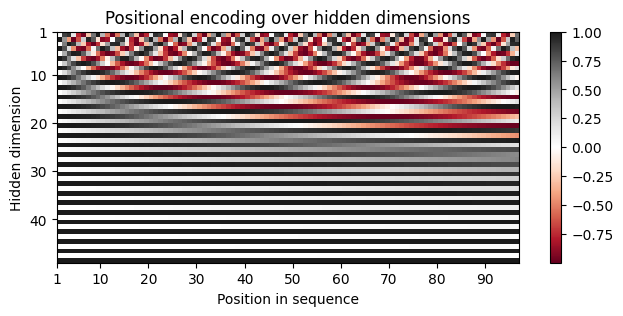

In [329]:
pos_embed_visual = Sinusoid(d_model=48, context_length=96)

P_visual = pos_embed_visual.P.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 3))
pos = ax.imshow(P_visual, cmap="RdGy", extent=(1, P_visual.shape[1] + 1, P_visual.shape[0] + 1, 1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1] + [i * 10 for i in range(1, 1 + P_visual.shape[1] // 10)])
ax.set_yticks([1] + [i * 10 for i in range(1, 1 + P_visual.shape[0] // 10)])
plt.show()

The positional encodings are depicted through sine and cosine functions, each
varying in wavelength across the hidden dimensions, to uniquely represent each
position. By examining these functions within individual hidden dimensions, we
gain deeper insights into the encoding patterns. Here, we present a
visualization of the positional encodings across hidden dimensions $d = 0, 1,
2, 3$ for the initial $16$ sequence positions {cite}`lippe2023uvadlc`.

In [330]:
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_positional_encoding(pe: np.ndarray, block_size: int, figsize: Tuple[int, int] = (12, 4)) -> None:
    """Plot positional encoding for each hidden dimension.

    Args:
        pe: Positional encoding array.
        composer_block_size: Block size of the composer.
        figsize: Figure size for the plot.
    """
    sns.set_theme()
    fig, ax = plt.subplots(2, 2, figsize=figsize)
    ax = [a for a_list in ax for a in a_list]

    for i, a in enumerate(ax):
        a.plot(np.arange(1, block_size + 1), pe[i, :block_size], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
        a.set_title(f"Encoding in hidden dimension d={i+1}")
        a.set_xlabel("Position in sequence", fontsize=10)
        a.set_ylabel("Positional encoding", fontsize=10)
        a.set_xticks(np.arange(1, 17))
        a.tick_params(axis='both', which='major', labelsize=10)
        a.tick_params(axis='both', which='minor', labelsize=8)
        a.set_ylim(-1.2, 1.2)

    fig.subplots_adjust(hspace=0.8)
    sns.reset_orig()
    plt.show()

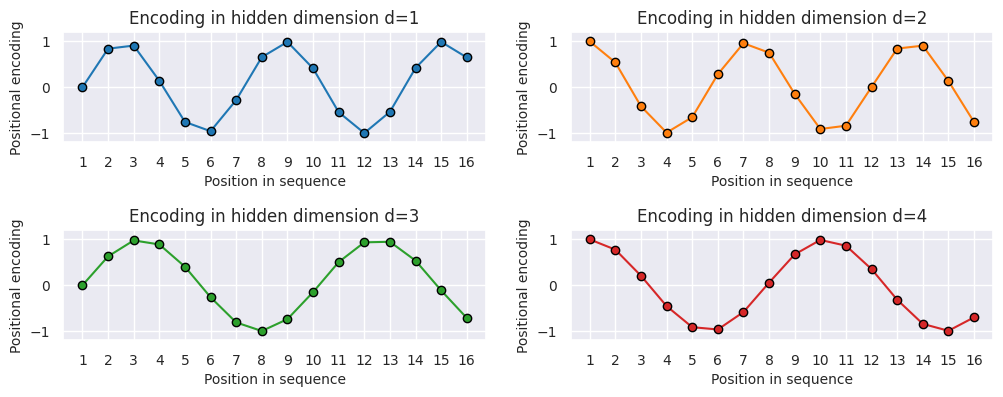

In [331]:
plot_positional_encoding(P_visual, 16)

As we can see, the patterns between the hidden dimension 1 and 2 only differ in
the starting angle. The wavelength is $2\pi$ , hence the repetition after
position 6 . The hidden dimensions 2 and 3 have about twice the wavelength {cite}`lippe2023uvadlc`.

### Positional Encodings via Embeddings

In practice, the positional encodings are learned as part of the GPT-2 {cite}`radford2019language`.
So we can replicate the same by using a `nn.Embedding` layer in PyTorch as in the token embeddings.

$\mathbf{W}_{p}$ is the positional embedding matrix. Each row of this matrix
corresponds to the embedding of a position in a sequence. This matrix is usually
of size $T \times D$, where $T$ is the maximum length of a sequence we allow in
the model, and $D$ is the dimension of the embedding space.

In other words, the $\mathbf{P}$ matrix introduced earlier has the same shape as
$\mathbf{W}_{p}$, and while the former is fixed, the latter is learned during
the training process.

In [343]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model: int, context_length: int) -> None:
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=context_length, embedding_dim=d_model)

    def forward(self, positions: torch.Tensor) -> torch.Tensor:
        return self.embedding(positions.to(device=self.embedding.weight.device))

In [353]:
generator = torch.Generator(device=composer.device)
generator.manual_seed(25)
seed_all(composer.seed, seed_torch=True, set_torch_deterministic=False)

pos_embed = PositionalEmbedding(d_model=composer.d_model, context_length=composer.block_size)
positions = torch.arange(start=0, end=composer.block_size, dtype=torch.long) # shape (t)
z0_pos_embed = pos_embed(positions)

z0_tok_embed_with_pos_embed = z0_tok_embed + z0_pos_embed
pprint(z0_tok_embed_with_pos_embed)

tensor([[[-0.9186,  0.6706,  1.4850, -0.4710],
│   │    [-0.9049,  2.3350,  3.0957, -0.1025],
│   │    [-0.7444, -0.7376,  2.6847, -0.9015],
│   │    [-0.4490, -1.7063, -2.5221,  0.3325],
│   │    [-1.4034, -2.2840,  0.4485,  0.6674],
│   │    [ 0.8796,  1.3154, -0.6523,  0.4923],
│   │    [ 2.3765,  1.7139,  2.1815, -0.0332],
│   │    [ 1.5345,  0.8230,  3.2535, -0.1055]]], grad_fn=<AddBackward0>)

## Self-Attention and Masked Self-Attention

In [37]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0, 10, (3, 2)).float()
c = a @ b
print("a=")
print(a)
print("--")
print("b=")
print(b)
print("--")
print("c=")
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


1. Tidy up positional encodings.

1. Insert arch diagram
2. change example since i changed seed.
3. Add cosine similarity from transformers notebook to show that embeddings in a subspace.
4. Add def/theorem/notation prf
5. Conditional and Joint probability
6. Model definition in page 5/
7. Loss see page 5/6
8. autoregressive self supervised def page 6
9. Insert intuition of using average of preceding tokens for self attention section:
    1. version 1: averaging past context with for loops, the weakest form of aggregation
    2. min 42 to min 58
    3. on intuition of softmax and weight distribution
10. Time and Space Complexity

## Conditional Probability

The GPT model, being autoregressive, directly models the **conditional
probability** of each token given all previous tokens in a sequence. This is the
core operational mechanism of the model, allowing it to predict the next token
based on the preceding context. The conditional probability for each token $x_t$
given its predecessors $x_{<t}$ is expressed as $P(x_t | x_{<t};
\Theta)$, where
$\Theta$ represents the model's parameters.

## Joint Probability

The **joint probability** of a sequence $\mathbf{x} = (x_1, x_2, ..., x_T)$
under the model is derived from the product of these conditional probabilities.
By assuming that the probability of each token can be modeled based on its
predecessors, the model implicitly defines a joint probability distribution over
sequences. This joint probability is represented by the product:

$$
P(\mathbf{x}; \Theta) = \prod_{t=1}^{T} P(x_t | x_{<t}; \Theta)
$$

This formulation shows that while the GPT model operates through conditional
probabilities, the product of these conditional probabilities across a sequence
results in the **joint probability** of the entire sequence. Thus, the GPT model
effectively learns the joint probability distribution over sequences in the
dataset by learning to predict the next token given its context, leveraging the
chain rule of probability.


{cite}`math11112451`

- https://devblogs.nvidia.com/how-optimize-data-transfers-cuda-cc/
- https://developer.nvidia.com/blog/how-overlap-data-transfers-cuda-cc/
- https://e2eml.school/transformers.html

**Positional Encoding**

- https://aman.ai/primers/ai/transformers/#positional-encoding
- https://d2l.ai/chapter_attention-mechanisms-and-transformers/self-attention-and-positional-encoding.html
- https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
- https://e2eml.school/transformers.html#positional_encoding

**Attention**

- [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)
- https://eugeneyan.com/writing/attention/

Softmax without scaling: tensor([2.0611e-09, 4.5398e-05, 9.9995e-01])
Softmax with scaling: tensor([0.2010, 0.3126, 0.4864])


[^1]: [OpenAI tiktoken](https://github.com/openai/tiktoken)
[^2]: [How to Optimize Data Transfers in CUDA C/C++](https://devblogs.nvidia.com/how-optimize-data-transfers-cuda-cc/)